# Projet 5 : Catégorisez automatiquement des questions

L'objectif de ce projet est d'appliquer des tags à des questions issues du site stackoverflow. Pour cela on va utiliser l'outil StackExchange qui permet de lancer des requêtes SQL sur la base de données de stackoverflow.

## Notebook 1 : Exploration
* Extraction des données

## Ressources intéressantes

MODELS : https://scikit-learn.org/stable/modules/classes.html#module-sklearn.multioutput
METRICS : https://scikit-learn.org/stable/modules/generated/sklearn.metrics.zero_one_loss.html#sklearn.metrics.zero_one_loss

LDA evaluation on sklearn and explanations https://github.com/derekgreene/topic-model-tutorial
LDA : https://towardsdatascience.com/end-to-end-topic-modeling-in-python-latent-dirichlet-allocation-lda-35ce4ed6b3e0
LDA Evaluatio : https://towardsdatascience.com/evaluate-topic-model-in-python-latent-dirichlet-allocation-lda-7d57484bb5d0
sklearn lda and nmf : https://medium.com/mlreview/topic-modeling-with-scikit-learn-e80d33668730
topic model with gensim : https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/
Try LSA (first you need to do TF-IDF) : https://mccormickml.com/2016/03/25/lsa-for-text-classification-tutorial/
complet lda with gensim choosing best k for Nbr topics : https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/#17howtofindtheoptimalnumberoftopicsforlda
automatic choice of K using HDP : https://datascience.stackexchange.com/questions/128/latent-dirichlet-allocation-vs-hierarchical-dirichlet-process

lda vs lsa vs plsa vs lda2vec : https://medium.com/nanonets/topic-modeling-with-lsa-psla-lda-and-lda2vec-555ff65b0b05
LDA evaluation : https://towardsdatascience.com/evaluate-topic-model-in-python-latent-dirichlet-allocation-lda-7d57484bb5d0

count vectorizer : 
https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

https://stackoverflow.com/questions/27697766/understanding-min-df-and-max-df-in-scikit-countvectorizer

utiliser sklearn.feature_extraction.text.CountVectorizer

### Stratification

http://videolectures.net/ecmlpkdd2011_tsoumakas_stratification/?q=stratification%20multi%20label

http://scikit.ml/api/skmultilearn.model_selection.iterative_stratification.html

## Librairies  utilisées

In [1]:
import pandas as pd
import numpy as np

# text preprocessing
import re
from string import punctuation
import nltk
from bs4 import BeautifulSoup
import spacy

# gensim
import gensim
from gensim.models import CoherenceModel
import gensim.corpora as corpora

# plotting tools
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import pyLDAvis
import pyLDAvis.gensim

# sklearn
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.multioutput import MultiOutputClassifier, ClassifierChain
from sklearn.multiclass import OneVsRestClassifier
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.metrics import accuracy_score, jaccard_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_validate, GridSearchCV, RandomizedSearchCV

nlp = spacy.load("en_core_web_sm")
#nltk.download()
n_jobs = -1 # enable multiprocessing

## Chargement des données

In [2]:
df = pd.read_csv('df_process.csv', sep=';')

In [3]:
df['Tags_process'] = df['Tags_process'].apply(lambda x: [text[1:-1] for text in x.strip('[]').split(', ')])
df['Tags'] = df['Tags'].apply(lambda x: [text[1:-1] for text in x.strip('[]').split(', ')])

In [4]:
df

,Tags,Title,Body,data_words,Body_process,Tags_process
0,"[node.js, npm]",Easy way to list node modules I have npm linked?,<p>I am looking for a command that will list t...,"['command', 'name', 'module', 'copy', 'path', ...",command name module copy path fact list module...,"[node.js, npm]"
1,"[python, pandas]",Appending to an empty DataFrame in Pandas?,<p>Is it possible to append to an empty data f...,"['data_frame', 'index', 'column', 'dataframe',...",data frame index column dataframe end e g,"[python, pandas]"
2,"[html, xhtml]",Why can't the <p> tag contain a <div> tag insi...,"<p>As far as I know, this is right:</p>\n\n<pr...","['one', 'one', 'tag', 'containment', 'relation...",one one tag containment relationship,[html]
3,"[android, view]",Android - get children inside a View?,<p>Given a View how can I get the child views ...,"['view', 'child', 'view', 'custom', 'view', 'd...",view child view custom view debugger view way ...,[android]
4,"[ios, arrays, swift]",Array extension to remove object by value,<pre><code>extension Array {\n func removeO...,"['method', 'signature', 'anyobject', 'way']",method signature anyobject way,"[ios, arrays, swift]"
...,...,...,...,...,...,...
29042,"[html, events, angular, typescript]",Detect click outside Angular component,<p>How can I detect clicks <em>outside</em> a ...,"['click', 'component']",click component,"[html, angular, typescript]"
29043,"[ios, iphone, objective-c, uiview, transition]","""From View Controller"" disappears using UIView...",<p>I got one problem and i have described it b...,"['problem', 'custom', 'transition', 'view', 'c...",problem custom transition view controller view...,"[ios, iphone, objective-c]"
29044,[swift],How to test equality of Swift enums with assoc...,<p>I want to test the equality of two Swift en...,"['equality', 'value', 'example', 'compiler', '...",equality value example compiler equality expre...,[swift]
29045,"[ios, swift, cocoa-touch, uiview, instantiation]",How do I write a custom init for a UIView subc...,<p>Say I want to <code>init</code> a <code>UIV...,"['subclass', 'swift', 'custom', 'function', 'p...",subclass swift custom function parameter strin...,"[ios, swift, cocoa-touch]"


# Apprentissage supervisé

## Train test split

### MultiLabelBinarizer

#### example

In [5]:
test = df['Tags_process'][0:2]
test

0      [node.js, npm]
1    [python, pandas]
Name: Tags_process, dtype: object

In [6]:
mlb = MultiLabelBinarizer()

In [7]:
mlb.fit_transform(test)

array([[1, 1, 0, 0],
       [0, 0, 1, 1]])

In [8]:
mlb.classes_

array(['node.js', 'npm', 'pandas', 'python'], dtype=object)

#### example train test split stratified in a multilabel problem

On crée un example similaire à notre problème où l'on va controler les proportions topic. On imagine que sur notre forum il y a 4 topics avec les proportions suivantes :
* android : 30 %
* machine learning : 60 %
* web : 9 %
* nvidia : 1 %

Pour chaque topic on a un post associé. Dans un premier temps on va écrire une fonction qui donne aléatoirement un post en respectant les proportions du forum.

In [9]:
def generatePost(dataframeSize):
    df = pd.DataFrame(columns=['Post','Tags','Topic'])
    
    for i in range(dataframeSize):
    
        rnd1 = np.random.random()
        rnd2 = np.random.randint(1,4)
        rnd3 = np.random.randint(1,6)

        # android
        if (rnd1<0.3):
            topic = 'android'
            tag_list = ['android','eclipse','java','user-interface','pixel']
            post_list = ['I got an error while running my Android project',
                        'Do Android devices have a unique ID',
                        'I have an EditText and a Button in my layout',
                        'What is the difference between Android units of measure?']
            tags = tag_list[:rnd3]
            post = post_list[rnd2]

        # machine learning
        elif(rnd1>=0.3 and rnd1<0.9):
            topic = 'machine learning'
            tag_list = ['machine-learning','python','pandas','numpy','tensorflow']
            post_list = ['“Large data” workflows using pandas',
                        'Peak signal detection in realtime timeseries data',
                        'TensorFlow, why was python the chosen language? ',
                        'Can anyone explain me StandardScaler? ']
            tags = tag_list[:rnd3]
            post = post_list[rnd2]  
            
        # web
        elif(rnd1>=0.9 and rnd1<0.99):
            topic = 'web'
            tag_list = ['html','https','browser','javascript','layout']
            post_list = ['How do you disable browser Autocomplete on web form field / input tag?',
                        'How do we control web page caching, across all browsers?',
                        '403 Forbidden vs 401 Unauthorized HTTP responses',
                        'Get the size of the screen, current web page and browser window']
            tags = tag_list[:rnd3]
            post = post_list[rnd2]
            
        # nvidia
        else:
            topic = 'nvidia'
            tag_list = ['nvidia','cuda','driver','gpu','pytorch']
            post_list = ['NVIDIA vs AMD: GPGPU performance',
                        'NVIDIA NVML Driver/library version mismatch',
                        'Understanding CUDA grid dimensions',
                        'How to check if pytorch is using the GPU?']
            tags = tag_list[:rnd3]
            post = post_list[rnd2]
   

        df.loc[i,:] = [post, tags, topic]
        
    return df

In [10]:
df_100 = generatePost(100)
df_1000 = generatePost(1000)
df_10000 = generatePost(10000)

/home/hugo/anaconda3/envs/projet5/lib/python3.8/site-packages/pandas/core/internals/blocks.py:983: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr_value = np.array(value)


In [11]:
df_100

,Post,Tags,Topic
0,Peak signal detection in realtime timeseries data,"[machine-learning, python, pandas, numpy]",machine learning
1,"TensorFlow, why was python the chosen language?",[machine-learning],machine learning
2,Do Android devices have a unique ID,[android],android
3,Peak signal detection in realtime timeseries data,"[machine-learning, python, pandas, numpy]",machine learning
4,"TensorFlow, why was python the chosen language?","[machine-learning, python]",machine learning
...,...,...,...
95,Can anyone explain me StandardScaler?,[machine-learning],machine learning
96,I have an EditText and a Button in my layout,"[android, eclipse, java, user-interface, pixel]",android
97,I have an EditText and a Button in my layout,"[android, eclipse, java, user-interface, pixel]",android
98,I have an EditText and a Button in my layout,"[android, eclipse]",android


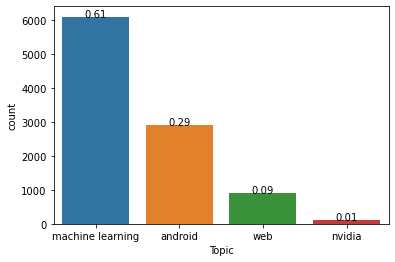

In [12]:
ax = sns.countplot(x='Topic', data=df_10000)
total = float(len(df_10000))
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height,
            '{:1.2f}'.format(height/total),
            ha="center") 

Lorque l'on fait un split des données en un jeu d'entrainement et de test, on peut soit :
* séparer aléatoirement sans tenir compte de y
* séparer aléatoirement en respectant les mêmes proportions des catégories de y



#### train test split classique

In [13]:
from sklearn.model_selection import train_test_split

#### train test split stratifié

In [14]:
from skmultilearn.model_selection import IterativeStratification

def iterative_train_test_split(X, y, train_size):
    """Custom iterative train test split which
    'maintains balanced representation with respect
    to order-th label combinations.'
    """
    stratifier = IterativeStratification(
        n_splits=2, order=1, sample_distribution_per_fold=[1.0-train_size, train_size, ])
    train_indices, test_indices = next(stratifier.split(X, y))
    X_train, y_train = X[train_indices], y[train_indices]
    X_test, y_test = X[test_indices], y[test_indices]
    return X_train, X_test, y_train, y_test

https://madewithml.com/courses/applied-ml/splitting/

#### comparaison

Afin de comparer les deux façons de faire la séparation des données, on va étudier la proportion des topics dans le jeu de test et d'entraînement. Dans l'idéal on cherche à obtenir la même proportion des topics dans le jeu d'entrainement et de test. On va comparer deux fonctions :
* train_test_split : séparation aléatoire non stratifiée
* iterative_train_test_split : séparation aléatoire stratifiée

In [15]:
def compareSplit(df):
    train_size = 0.8
    test_size = 1-train_size
    # train test split without stratifying
    df_no_strat = df.copy()
    X = df_no_strat[['Post','Topic']]
    y = df_no_strat['Tags']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42, shuffle=False)
    df_no_strat['Set'] = 'train'
    df_no_strat.loc[X_test.index,'Set'] = 'test'
    # train test split with stratifying
    df_copy = df.copy()
    X = df_copy[['Post','Topic']].values
    y = df_copy['Tags'].values
    mlb = MultiLabelBinarizer()
    y_mlb = mlb.fit_transform(y)
    X_train, X_test, y_train, y_test = iterative_train_test_split(X, y_mlb, train_size=train_size)
    df_train = pd.DataFrame(data={'Post':X_train[:,0], 'Topic':X_train[:,1], 'Tags':mlb.inverse_transform(y_train), 'Set':'train'})
    df_test = pd.DataFrame(data={'Post':X_test[:,0], 'Topic':X_test[:,1], 'Tags':mlb.inverse_transform(y_test), 'Set':'test'})
    df_strat = pd.concat([df_train, df_test], axis=0, ignore_index=True)
    # plot
    fig, axs = plt.subplots(1, 2, figsize=(15, 6))
    sns.countplot(ax=axs[0], x='Set', hue='Topic', hue_order=['machine learning','android','web','nvidia'], data=df_no_strat)
    axs[0].set_title('train_test_split')
    for p in axs[0].patches:
        total = len(df)*train_size if (p.get_x() < 0.5) else len(df)*test_size
        height = p.get_height()
        axs[0].text(p.get_x()+p.get_width()/2,height,'{:1.2f}'.format(height/total),ha="center")
    sns.countplot(ax=axs[1], x='Set', hue='Topic', hue_order=['machine learning','android','web','nvidia'], data=df_strat)
    axs[1].set_title('iterative_train_test_split')
    for p in axs[1].patches:
        total = len(df)*train_size if (p.get_x() < 0.5) else len(df)*test_size
        height = p.get_height()
        axs[1].text(p.get_x()+p.get_width()/2,height,'{:1.2f}'.format(height/total),ha="center")
     
    

#### dataframe 100 entrées

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


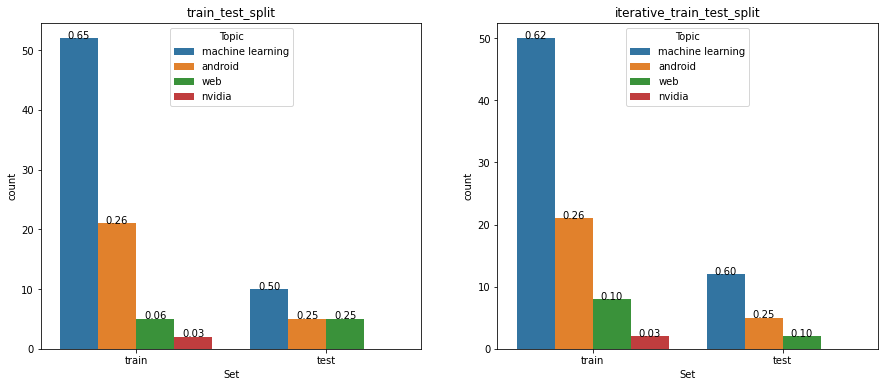

In [16]:
compareSplit(df_100)

#### dataframe 1000 entrées

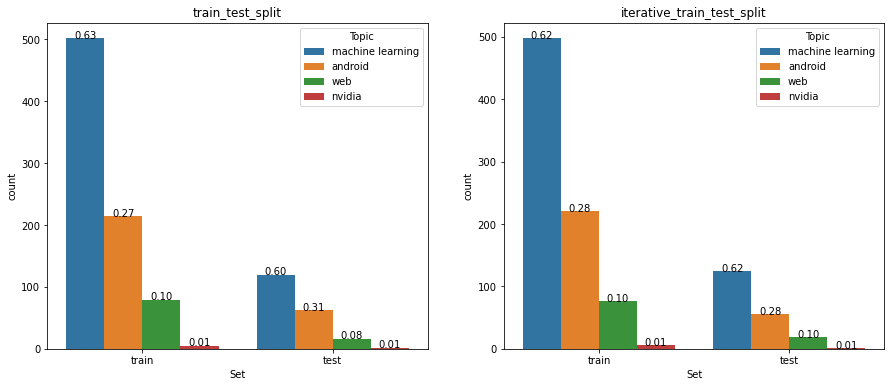

In [17]:
compareSplit(df_1000)

#### dataframe 10 000 entrées

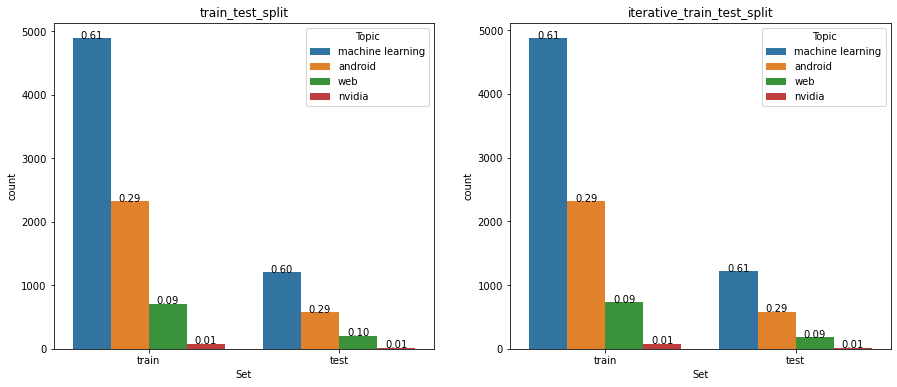

In [18]:
compareSplit(df_10000)

### Cas d'étude

In [19]:
X = df['Body_process'].values
y = df['Tags_process'].values

#### Multilabel binarizer

In [20]:
mlb = MultiLabelBinarizer()
y_mlb = mlb.fit_transform(y)

In [21]:
X_train, X_test, y_train, y_test = iterative_train_test_split(X, y_mlb, train_size = 0.2)

In [22]:
y_train.shape

(5827, 100)

https://towardsdatascience.com/journey-to-the-center-of-multi-label-classification-384c40229bff

https://towardsdatascience.com/multi-label-text-classification-5c505fdedca8

### Métrique : Jaccard score

On cherche à faire de la classification multilabel. C'est à dire qu'un poste peut être associé à plusieurs tags. Cela signifie que la prédiction que l'on va faire va peut-être trouver un bon tag et des mauvais tags. On ne peut donc pas raisonner avec du tout ou rien. Le coefficient de jaccard permet de prendre en compte les intersections et union des ensembles.

#### exemple

In [23]:
y_true = np.array([[0, 1, 1],[1, 1, 0]])
y_pred = np.array([[1, 1, 1],[1, 0, 0]])
jaccard_score(y_true, y_pred, average='macro')

0.6666666666666666

### Bag of words representation

#### CountVectorizer

In [24]:
preprocessor_cv = Pipeline(steps=[('transformer', CountVectorizer(lowercase=False, max_df=0.05, min_df=0.01))])

#### TfidfVectorizer

In [25]:
preprocessor_tv = Pipeline(steps=[('transformer', TfidfVectorizer(lowercase=False, max_df=0.05, min_df=0.01))])

### Classifier Chain

#### Logistic regression

In [26]:
base_lr = LogisticRegression(solver='lbfgs', random_state=0)
chain_lr = ClassifierChain(base_lr, order='random', random_state=0)

#### Random forest classifier

In [27]:
base_rf = RandomForestClassifier(random_state=0)
chain_rf = ClassifierChain(base_rf, order='random', random_state=0)

#### Gradient boosting classifier

In [28]:
base_gb = GradientBoostingClassifier(random_state=0)
chain_gb = ClassifierChain(base_gb, order='random', random_state=0)

### OneVsRest Classifier

#### Logistic regression

In [29]:
base_lr = LogisticRegression(solver='lbfgs', random_state=0)
ovr_lr = OneVsRestClassifier(base_lr, n_jobs=n_jobs)

#### Random forest classifier

In [30]:
base_rf = RandomForestClassifier(random_state=0)
ovr_rf = OneVsRestClassifier(base_rf, n_jobs=n_jobs)

#### Gradiant boosting classifier

In [31]:
base_gb = GradientBoostingClassifier(random_state=0)
ovr_gb = OneVsRestClassifier(base_gb, n_jobs=n_jobs)

 ### Evaluation

In [32]:
pipeline_dict = {
    'logistic regression CC CV':Pipeline(steps=[('preprocessor', preprocessor_cv),('classifier', chain_lr)]),
    'logistic regression CC TV':Pipeline(steps=[('preprocessor', preprocessor_tv),('classifier', chain_lr)]),
    'logistic regression OVR CV':Pipeline(steps=[('preprocessor', preprocessor_cv),('classifier', ovr_lr)]),
    'logistic regression OVR TV':Pipeline(steps=[('preprocessor', preprocessor_tv),('classifier', ovr_lr)]),
    'random forest CC CV':Pipeline(steps=[('preprocessor', preprocessor_cv),('classifier', chain_rf)]),
    'random forest CC TV':Pipeline(steps=[('preprocessor', preprocessor_tv),('classifier', chain_rf)]),
    'random forest OVR CV':Pipeline(steps=[('preprocessor', preprocessor_cv),('classifier', ovr_rf)]),
    'random forest OVR TV':Pipeline(steps=[('preprocessor', preprocessor_tv),('classifier', ovr_rf)]),
    'gradient boosting CC CV':Pipeline(steps=[('preprocessor', preprocessor_cv),('classifier', chain_gb)]),
    'gradient boosting CC TV':Pipeline(steps=[('preprocessor', preprocessor_tv),('classifier', chain_gb)]),
    'gradient boosting OVR CV':Pipeline(steps=[('preprocessor', preprocessor_cv),('classifier', ovr_gb)]),
    'gradient boosting OVR TV':Pipeline(steps=[('preprocessor', preprocessor_tv),('classifier', ovr_gb)])
}

In [33]:
df_score = pd.DataFrame(columns=['model','jaccard','score'])
df_time = pd.DataFrame(columns=['model','temps en s','time'])

In [34]:
for i, pipeline in zip(range(0,len(pipeline_dict)*2,2), pipeline_dict):
    model_name = pipeline
    print(model_name)
    model = pipeline_dict[pipeline]
    cv_results = cross_validate(model, X_train, y_train, scoring='jaccard_macro', cv=5, return_train_score=True, n_jobs=n_jobs)
    # On stocke les résultats
    df_score.loc[i] = [model_name,cv_results['train_score'].mean(),'train']
    df_score.loc[i+1] = [model_name,cv_results['test_score'].mean(),'validation']
    df_time.loc[i] = [model_name,cv_results['fit_time'].mean(),'fit']
    df_time.loc[i+1] = [model_name,cv_results['score_time'].mean(),'score']
    print("validation score : %.3f" % cv_results['test_score'].mean())

logistic regression CC CV
validation score : 0.110
logistic regression CC TV
validation score : 0.064
logistic regression OVR CV
validation score : 0.109
logistic regression OVR TV
validation score : 0.064
random forest CC CV
validation score : 0.094
random forest CC TV
validation score : 0.075
random forest OVR CV
validation score : 0.096
random forest OVR TV
validation score : 0.075
gradient boosting CC CV
validation score : 0.112
gradient boosting CC TV
validation score : 0.108
gradient boosting OVR CV
validation score : 0.115
gradient boosting OVR TV
validation score : 0.110


In [35]:
df_score[df_score.score == 'validation']

,model,jaccard,score
1,logistic regression CC CV,0.110127,validation
3,logistic regression CC TV,0.064201,validation
5,logistic regression OVR CV,0.108936,validation
7,logistic regression OVR TV,0.063926,validation
9,random forest CC CV,0.093781,validation
11,random forest CC TV,0.075054,validation
13,random forest OVR CV,0.095576,validation
15,random forest OVR TV,0.074746,validation
17,gradient boosting CC CV,0.111744,validation
19,gradient boosting CC TV,0.108370,validation


In [36]:
index_CC = df_score['model'].apply(lambda x: 'CC' in x)
df_score['methode'] = 'OneVsRest Classifier'
df_score.loc[index_CC,'methode'] = 'Classifier Chain'

In [37]:
index_CV = df_score['model'].apply(lambda x: 'CV' in x)
df_score['vectorizer'] = 'TfidfVectorizer'
df_score.loc[index_CV,'vectorizer'] = 'CountVectorizer'

In [38]:
index_RF = df_score['model'].apply(lambda x: 'random forest' in x)
index_GB = df_score['model'].apply(lambda x: 'gradient boosting' in x)
df_score['base'] = 'logistic regression'
df_score.loc[index_RF,'base'] = 'random forest'
df_score.loc[index_GB,'base'] = 'gradient boosting'

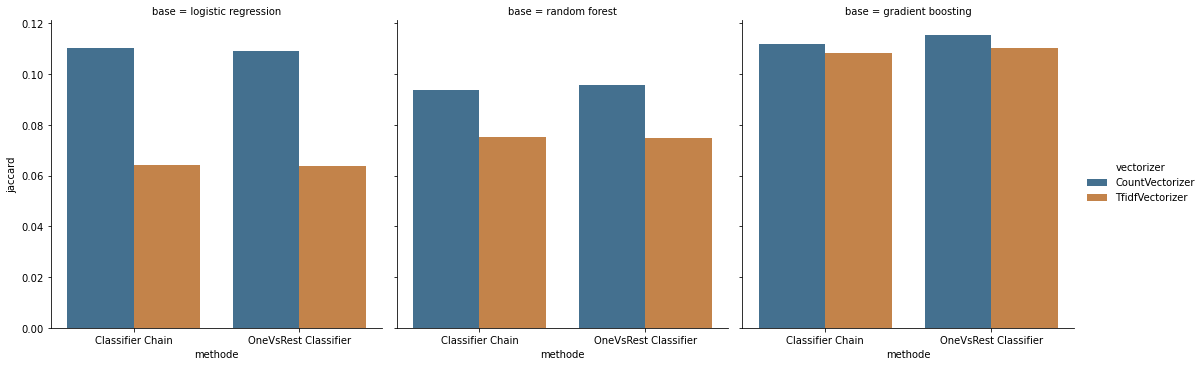

In [39]:
sns.catplot(x='methode', y='jaccard', col='base', hue='vectorizer', data=df_score[df_score.score == 'validation'], saturation=.5, kind="bar", ci=None)

On peut conclure que les deux meilleurs base de modèles sont :
* gradient boosting
* logistic regression

Classifier Chain et CountVectorizer permettent d'obtenir les meilleurs résultats.

### Comparaison des meilleurs modèles

In [40]:
grid_list = []

#### Logistic Regression

https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

In [41]:
preprocessor_lr = Pipeline(steps=[('transformer', CountVectorizer(lowercase=False, max_df=0.05, min_df=0.01))])

In [42]:
base_lr = LogisticRegression(solver='saga', random_state=0)
chain_lr = ClassifierChain(base_lr, order='random', random_state=0)

In [43]:
lr_pipeline = Pipeline(steps=[('preprocessor', preprocessor_lr),('model', chain_lr)])

Il existe de nombreux hyper-paramètres pour le model de gradient boosting.

In [44]:
lr_pipeline['model'].get_params()

{'base_estimator__C': 1.0,
 'base_estimator__class_weight': None,
 'base_estimator__dual': False,
 'base_estimator__fit_intercept': True,
 'base_estimator__intercept_scaling': 1,
 'base_estimator__l1_ratio': None,
 'base_estimator__max_iter': 100,
 'base_estimator__multi_class': 'auto',
 'base_estimator__n_jobs': None,
 'base_estimator__penalty': 'l2',
 'base_estimator__random_state': 0,
 'base_estimator__solver': 'saga',
 'base_estimator__tol': 0.0001,
 'base_estimator__verbose': 0,
 'base_estimator__warm_start': False,
 'base_estimator': LogisticRegression(random_state=0, solver='saga'),
 'cv': None,
 'order': 'random',
 'random_state': 0}

On sélectionne les hyper-paramètres suivant :

In [45]:
param_grid = {
    'preprocessor__transformer__min_df':[0.01],
    'preprocessor__transformer__max_df':[0.05],
    'model__base_estimator__C':np.logspace(-2,2,5),
    'model__base_estimator__penalty':["l1","l2"]
}

On effectue GridSearchCV et on stocke les résultats dans une liste.

In [46]:
grid = GridSearchCV(lr_pipeline, param_grid, scoring='jaccard_macro', cv=5, return_train_score=True, n_jobs=n_jobs)
grid.fit(X_train, y_train)
grid_list.append(grid)

/home/hugo/anaconda3/envs/projet5/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/home/hugo/anaconda3/envs/projet5/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/home/hugo/anaconda3/envs/projet5/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/home/hugo/anaconda3/envs/projet5/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/home/hugo/anaconda3/envs/projet5/lib/python3.8/site-pac

/home/hugo/anaconda3/envs/projet5/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/home/hugo/anaconda3/envs/projet5/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/home/hugo/anaconda3/envs/projet5/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/home/hugo/anaconda3/envs/projet5/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/home/hugo/anaconda3/envs/projet5/lib/python3.8/site-pac

/home/hugo/anaconda3/envs/projet5/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/home/hugo/anaconda3/envs/projet5/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/home/hugo/anaconda3/envs/projet5/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/home/hugo/anaconda3/envs/projet5/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/home/hugo/anaconda3/envs/projet5/lib/python3.8/site-pac

#### Gradient Boosting

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html

In [47]:
preprocessor_gb = Pipeline(steps=[('transformer', CountVectorizer(lowercase=False, max_df=0.05, min_df=0.01))])

In [48]:
base_gb = GradientBoostingClassifier(random_state=0)
ovr_gb = OneVsRestClassifier(base_gb, n_jobs=n_jobs)

In [49]:
gb_pipeline = Pipeline(steps=[('preprocessor', preprocessor_gb),('model', ovr_gb)])

Il existe de nombreux hyper-paramètres pour le model de gradient boosting.

In [50]:
gb_pipeline['model'].get_params()

{'estimator__ccp_alpha': 0.0,
 'estimator__criterion': 'friedman_mse',
 'estimator__init': None,
 'estimator__learning_rate': 0.1,
 'estimator__loss': 'deviance',
 'estimator__max_depth': 3,
 'estimator__max_features': None,
 'estimator__max_leaf_nodes': None,
 'estimator__min_impurity_decrease': 0.0,
 'estimator__min_impurity_split': None,
 'estimator__min_samples_leaf': 1,
 'estimator__min_samples_split': 2,
 'estimator__min_weight_fraction_leaf': 0.0,
 'estimator__n_estimators': 100,
 'estimator__n_iter_no_change': None,
 'estimator__random_state': 0,
 'estimator__subsample': 1.0,
 'estimator__tol': 0.0001,
 'estimator__validation_fraction': 0.1,
 'estimator__verbose': 0,
 'estimator__warm_start': False,
 'estimator': GradientBoostingClassifier(random_state=0),
 'n_jobs': -1}

On sélectionne les hyper-paramètres suivant :

In [51]:
param_grid = {
    'preprocessor__transformer__min_df':[0.01],
    'preprocessor__transformer__max_df':[0.05],
    'model__estimator__max_depth': [None, 5, 10],    
    'model__estimator__max_features': ['auto', 'sqrt'],
    'model__estimator__min_samples_leaf': [1, 5, 10],
    'model__estimator__min_samples_split': [2, 10, 20],
    'model__estimator__n_estimators': [50, 100, 150]
}

On effectue GridSearchCV et on stocke les résultats dans une liste.

In [52]:
grid = GridSearchCV(gb_pipeline, param_grid, scoring='jaccard_macro', cv=5, return_train_score=True, n_jobs=n_jobs)
grid.fit(X_train, y_train)
grid_list.append(grid)

/home/hugo/anaconda3/envs/projet5/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/home/hugo/anaconda3/envs/projet5/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [0.10569642 0.10529271 0.10341937 0.10491721 0.10387212 0.10240675
 0.10815935 0.10404419 0.10271582 0.12118709 0.1155869  0.11324889
 0.12118709 0.1155869  0.11324889 0.12175405 0.11924992 0.11622046
 0.11623918 0.12006937 0.11623669 0.11623918 0.12006937 0.11623669
 0.11623918 0.12006937 0.11623669 0.09909567 0.10364927 0.1045745
 0.10164252 0.10363498 0.10250273 0.10569397 0.10849964 0.11005037
 0.11200568 0.11740438 0.11688662 0.11200568 0.11740438 0.11688662
 0.11097551 0.11531616 0.1171094  0.10801704 0.11937746 0.12296569
 0.10801704 0.11937746 0.12296569

On écrit une fonction qui va retourner le meilleur score de cross-validation pour chaque modèle. Cette fonction retourne les résultats sous forme de dataframe.

In [53]:
def best_grid(grid_list):
    df_score = pd.DataFrame(columns=['model','jaccard','score'])
    df_time = pd.DataFrame(columns=['model','temps en s','time'])
    
    for i, grid in zip(range(0,len(grid_list)*2,2), grid_list):
        best_model = grid.best_estimator_
        model_name = str(grid.best_estimator_['model']).split('(')[1].split('=')[1]
        print(model_name)
        best_model_index = grid.best_index_
        train_score = grid.cv_results_['mean_train_score'][best_model_index]
        test_score = grid.cv_results_['mean_test_score'][best_model_index]
        fit_time = grid.cv_results_['mean_fit_time'][best_model_index]
        score_time = grid.cv_results_['mean_score_time'][best_model_index]
        # On stocke les résultats
        df_score.loc[i] = [model_name,train_score,'train']
        df_score.loc[i+1] = [model_name,test_score,'validation']
        df_time.loc[i] = [model_name,fit_time,'fit']
        df_time.loc[i+1] = [model_name,score_time,'score']
        print("Meilleur score validation : %.3f" % df_score.loc[i+1,'jaccard'])

    return df_score, df_time

In [54]:
df_score, df_time = best_grid(grid_list)

LogisticRegression
Meilleur score validation : 0.116
GradientBoostingClassifier
Meilleur score validation : 0.127


On peut maintenant visualiser les meilleurs résultats moyens obtenus pour chaque modèle.

<AxesSubplot:xlabel='jaccard', ylabel='model'>

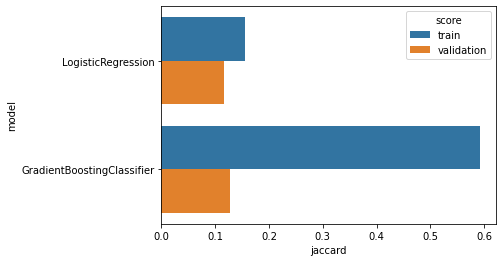

In [55]:
sns.barplot(x='jaccard', y='model', hue='score', data=df_score)

[None]

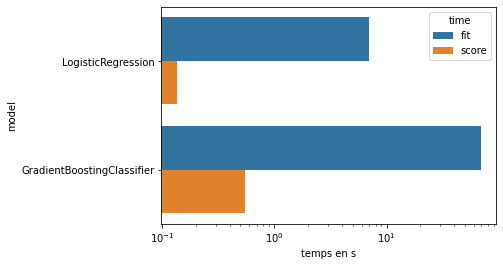

In [56]:
g = sns.barplot(x='temps en s', y='model', hue='time', data=df_time)
g.set(xscale="log")

In [57]:
grid_list[1].best_params_

{'model__estimator__max_depth': 5,
 'model__estimator__max_features': 'auto',
 'model__estimator__min_samples_leaf': 5,
 'model__estimator__min_samples_split': 2,
 'model__estimator__n_estimators': 150,
 'preprocessor__transformer__max_df': 0.05,
 'preprocessor__transformer__min_df': 0.01}

In [58]:
grid_list[1].best_score_

0.1270140461570569

### Optimisation finale

In [77]:
preprocessor_gb = Pipeline(steps=[('transformer', CountVectorizer(lowercase=False))])

In [78]:
base_gb = GradientBoostingClassifier(random_state=0)
ovr_gb = OneVsRestClassifier(base_gb, n_jobs=n_jobs)

In [79]:
gb_pipeline = Pipeline(steps=[('preprocessor', preprocessor_gb),('model', ovr_gb)])

In [80]:
param_grid = {
    'preprocessor__transformer__min_df':[0,0.01,0.02],
    'preprocessor__transformer__max_df':[0.03,0.05,0.07,0.09,0.11],
    'model__estimator__max_depth': [5],    
    'model__estimator__max_features': ['auto'],
    'model__estimator__min_samples_leaf': [5],
    'model__estimator__min_samples_split': [2],
    'model__estimator__n_estimators': [150]
}

In [81]:
grid = GridSearchCV(gb_pipeline, param_grid, scoring='jaccard_macro', cv=5, return_train_score=True, n_jobs=n_jobs)
grid.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        Pipeline(steps=[('transformer',
                                                         CountVectorizer(lowercase=False))])),
                                       ('model',
                                        OneVsRestClassifier(estimator=GradientBoostingClassifier(random_state=0),
                                                            n_jobs=-1))]),
             n_jobs=-1,
             param_grid={'model__estimator__max_depth': [5],
                         'model__estimator__max_features': ['auto'],
                         'model__estimator__min_samples_leaf': [5],
                         'model__estimator__min_samples_split': [2],
                         'model__estimator__n_estimators': [150],
                         'preprocessor__transformer__max_df': [0.03, 0.05, 0.07,
                                                               0.09, 0.11],
      

In [82]:
grid.best_params_

{'model__estimator__max_depth': 5,
 'model__estimator__max_features': 'auto',
 'model__estimator__min_samples_leaf': 5,
 'model__estimator__min_samples_split': 2,
 'model__estimator__n_estimators': 150,
 'preprocessor__transformer__max_df': 0.11,
 'preprocessor__transformer__min_df': 0}

In [83]:
grid.best_score_

0.2553593219129562

### Apprentissage semi suppervisé

lda score utiliser countvectorizer

In [84]:
preprocessor_sm = Pipeline(steps=[('transformer', CountVectorizer(lowercase=False)), ('lda', LatentDirichletAllocation())])

In [85]:
base_gb = GradientBoostingClassifier(random_state=0)
ovr_gb = OneVsRestClassifier(base_gb, n_jobs=n_jobs)

In [86]:
gb_pipeline = Pipeline(steps=[('preprocessor', preprocessor_sm),('model', ovr_gb)])

In [87]:
param_grid = {
    'preprocessor__transformer__min_df':[0,0.01,0.02],
    'preprocessor__transformer__max_df':[0.03,0.05,0.07,0.09,0.11],
    'model__estimator__max_depth': [5],    
    'model__estimator__max_features': ['auto'],
    'model__estimator__min_samples_leaf': [5],
    'model__estimator__min_samples_split': [2],
    'model__estimator__n_estimators': [150],
     'preprocessor__lda__n_components':[15,75,375]
}

In [88]:
grid_semi_supervised = GridSearchCV(gb_pipeline, param_grid, scoring='jaccard_macro', cv=5, return_train_score=True, n_jobs=n_jobs)
grid_semi_supervised.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        Pipeline(steps=[('transformer',
                                                         CountVectorizer(lowercase=False)),
                                                        ('lda',
                                                         LatentDirichletAllocation())])),
                                       ('model',
                                        OneVsRestClassifier(estimator=GradientBoostingClassifier(random_state=0),
                                                            n_jobs=-1))]),
             n_jobs=-1,
             param_grid={'model__estimator__max_depth': [5],
                         'model__estimator__max_features': ['auto'],
                         'model__estimator__min_samples_leaf': [5],
                         'model__estimator__min_samples_split': [2],
                         'model__estimator__n_estimators': [150],
            

In [89]:
grid_semi_supervised.best_params_

{'model__estimator__max_depth': 5,
 'model__estimator__max_features': 'auto',
 'model__estimator__min_samples_leaf': 5,
 'model__estimator__min_samples_split': 2,
 'model__estimator__n_estimators': 150,
 'preprocessor__lda__n_components': 375,
 'preprocessor__transformer__max_df': 0.09,
 'preprocessor__transformer__min_df': 0}

In [90]:
grid_semi_supervised.best_score_

0.14270057848016043

On ne peut pas utiliser RF ou GB ou RL seul pour faire de la classification multi label. Il faut passer par une méthode one versus rest. Ou bien par le classfier chain. One versus rest principe prend les données d'une classe par modèle. classifier chain se sert des sorties d'un modèle pour faire les features du suivant.

utiliser meilleur modèle pour API (semi supervisé si c'est le meilleur). API interface avec 2 saisies Titre et description. Sauvegarder modèle avec pickle. Charge le modèle puis predict.